In [2]:
#hide
import sys
from IPython.display import HTML, display, Image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# import proplot as plot

sys.path.append('/Users/46h/Research/code/accphys/')
from tools import (
    plotting as myplt,
    animation as myanim,
    coupling as bl,
    utils,
    matrix_lattice as ml,
    envelope_analysis as ea
)
from tools.utils import play, show
plt.rcParams['animation.html'] = 'jshtml'
plt.rcParams['animation.embed_limit'] = np.inf

# Coupled Parametric Oscillators
> Studying particle motion in the presence of time-dependent coupled linear forces.

- toc: true 
- badges: false
- comments: true
- categories: [physics]
- image: images/chart-preview.png

## Introduction 

In a [previous post](https://austin-hoover.github.io/blog/physics/accelerators/2021/01/21/parametric_oscillators.html) we examined the solutions to an equation of motion describing a parametric oscillator, which is a harmonic oscillator whose physical properties are time-dependent (but not dependent on the state of the oscillator). This problem was motivated by describing the transverse oscillations of a particle in an accelerator. In this post, the treatment will be extended to a *coupled* parametric oscillator. Basically, we are trying to solve the following equation of motion:

$$x'' + k_{11}(s)x + k_{13}(s)y + k_{14}(s)y',$$
$$y'' + k_{33}(s)y + k_{31}(s)x + k_{32}(s)x',$$

where the prime denotes differentiation with respect to $s$. We also assume that each of the $k_{ij}$ coefficients are periodic, so $k_{ij}(s + L) = k_{ij}(s)$ for some $L$. 

### Motivation 

The previous post discussed dipole and quadrupole magnetic fields, which have the special property that their fields depend linearly on $x$ and $y$, and are also uncoupled. Of course there are many other configurations possible. First, consider a solenoid magnet:

<img src="images_2021-01-25/solenoid.jpg" width=400>
<figcaption>Credit: brilliant.org</figcaption>

The field within the coils points in the longitudinal direction, and is approximatly constant ($\mathbf{B}_{sol} = B_0\hat{s}$). Plugging this into the Lorentz force equation we find: 

$$\dot{\mathbf{v}} = \frac{q}{m} \mathbf{v} \times \mathbf{B} = \frac{qB_0}{m}\left({v_y\hat{x} - v_x\hat{y}}\right).$$

This means the motion in $x$ depends on the velocity in $y$, and vice versa, so this will contribute to $k_{14}$ and $k_{32}$. Next we can consider transverse magnetic fields, for which the general expression can be written as

$$B_y + iB_x = B_{ref}\sum_{n=1}^{\infty}\left({B_n + iA_n}\right)\left(\frac{x + iy}{R_{ref}}\right)^{n-1}.$$

$B_{ref}$ and $R_{ref}$ are a reference field strength and radius, respectively; just consider them to be constants. We then have the normal multiple coefficients $B_n$, and the skew multipole coefficients $A_n$. The field lines corresponding to the first few normal multipole coefficients are shown below.

<br>
<img src="images_2021-01-25/multipoles.png">
<figcaption>Credit: Jeff Holmes</figcaption>
<br>

The skew multipole terms are found by rotating these fields by 45 degrees. We won't deal with anything higher than $n = 2$, since these fields contain nonlinear terms. What we will focus on is $A_2$, the skew quadrupole coefficient. This coefficient is present whenever a quadrupole magnet is tilted in the transverse plane; the result is a coupling between the motion in one plane and the position in the other, which contributes to the $k_{13}$ and $k_{31}$ terms.

### Approach

Let us review the approach we took in analysing the 1D parametric oscillator. We observed that the particles travel along the boundary of an ellipse in 2D phase space, the area of which is a constant of the motion (we will denote this area by $\epsilon_x$). To understand the motion, we just need to know the dimensions and orientation of this ellipse, as well as the location of the particle on the ellipse boundary. The former is determined from the parameters: $\alpha_x$ and $\beta_x$, and the latter by the phase $\mu_x$. All the subscripts can be replaced by $y$ to handle the vertical motion.

We can also write a transfer matrix $\mathbf{M}$ from these parameters which connects the initial and final phase space coordinates after tracking through one period. This matrix can be factored into three steps: 1) deformation of the ellipse into a circle (while preserving its area), 2) rotation around the circle by the phase advance, 3) undo the original transformation. 

Maybe we can do a similar thing for coupled motion. We now have four dimensions in phase space: $x$, $y$, $x'$, and $y'$, so we need to observe each of the 2D projections of this space (six in total). Maybe we can do something similar to the 1D case... let's track a particle in a lattice with a nonzero skew quadrupole coefficient, plotting its coordinates at one position in the lattice after every period.

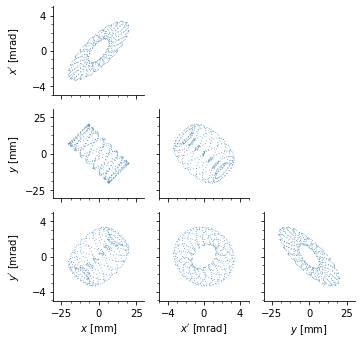

In [4]:
#hide
lattice = ml.fodo(0.2, 0.2, 5.0, start='drift', quad_tilt=1)

nturns = 500
eps1 = 42.5 # [mm-mrad]
eps2 = 7.5 # [mm-mrad]
psi1 = 0 # initial phase of eigenvector 1
psi2 = np.radians(90) # initial phase of eigenvector 2

# Form coordinate vector
x1 = np.real(np.sqrt(eps1) * lattice.v1 * np.exp(1j*psi1)) # mode 1 contribution
x2 = np.real(np.sqrt(eps2) * lattice.v2 * np.exp(1j*psi2)) # mode 2 contribution
x = x1 + x2

# Track
X1 = lattice.track_part(x1, nturns)
X2 = lattice.track_part(x2, nturns)
X = lattice.track_part(x, nturns)

myplt.corner(X, diag_kind=None);

In [ ]:
#hide_input
anim = myanim.corner_onepart(
    X, 
    dims='all', 
    figsize=8, 
    show_history=True, 
    text_fmt='Period = {}',
    fps=30,
    label_kws=dict(fontsize='large'),
    text_kws=dict(fontsize='large'),
    grid_kws=dict(alpha=0.11),
    history_kws=dict(s=5, alpha=0.2, color='black'),
    color='black',
    s=10
)
anim

The particle traces interesting donut-like shapes instead of ellipses. There are clearly two frequencies involved, which we see if we plot the $x$ and $y$ position vs period number and take the FFT. This is typical of a coupled oscillator. Usually a coupled oscillator is understood as the superposition of [normal modes](https://en.wikipedia.org/wiki/Normal_mode), each of which corresponds to a single frequency. For example, consider two masses connected with a spring. The system has a *breathing mode*, in which masses move in opposite directions, and a *sloshing mode*, in which the masses move in the same direction. The motion is simply the sum of these two modes. We will try to do something similar for a coupled parameteric oscillator.

## Transfer matrix eigenvectors  

## Conclusion